In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [4]:
#!unzip yawn_eye.zip

In [5]:
cd yawn_eye

/content/drive/MyDrive/yawn_eye


In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory="train",
    labels='inferred',
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.1,
    subset="training",
    seed=1024
)

Found 2467 files belonging to 4 classes.
Using 2221 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory="train",
    labels='inferred',
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.1,
    subset="validation",
    seed=1024
)

Found 2467 files belonging to 4 classes.
Using 246 files for validation.


In [8]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory="test",
    labels="inferred",
    batch_size=32,
    image_size=(256,256),
    validation_split=None,
)

Found 433 files belonging to 4 classes.


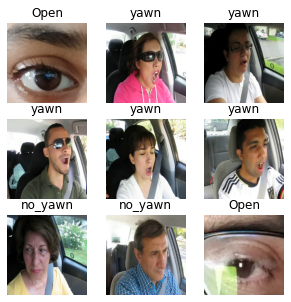

In [ ]:
class_names=train_ds.class_names
plt.figure(figsize=(5, 5))
for images ,labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

In [9]:
aututune = tf.data.AUTOTUNE
train_ds=train_ds.cache().prefetch(buffer_size=aututune)
val_ds=val_ds.cache().prefetch(buffer_size=aututune)
test_ds=test_ds.cache().prefetch(buffer_size=aututune)

In [10]:
"""data_augmentation= tf.keras.Sequential(
    [
     tf.keras.layers.experimental.preprocessing.RandomZoom((-0.2, -0.1)),
     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
     tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)"""

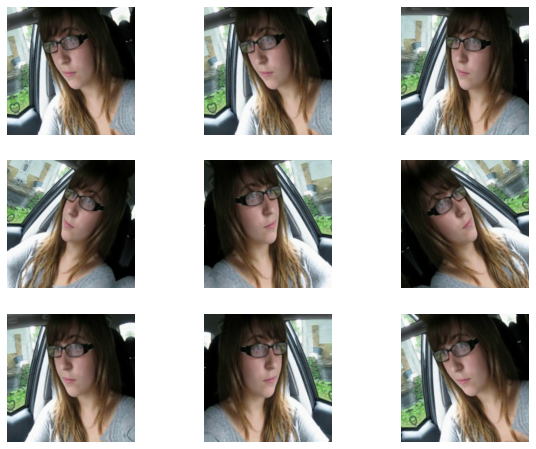

In [ ]:
image , label= next(iter(train_ds))
plt.figure(figsize=(10,8))
first_image=image[13]
for i in range(9):
  ax=plt.subplot(3,3,i+1)
  augmented_image=data_augmentation(first_image)
  plt.imshow(augmented_image.numpy().astype("uint8"))
  plt.axis('off')

In [11]:
model_vgg=tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=(256,256,3))

80134624/80134624 [==============================] - 3s 0us/step


In [12]:
model_vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [13]:
model_vgg.trainable=False

In [25]:
inputs= tf.keras.Input(shape=(256,256,3))
#x=data_augmentation(inputs)
x=model_vgg(inputs,training=False)
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dense(32,activation='elu',kernel_regularizer='l1_l2', bias_regularizer='l1_l2')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dense(64,activation='elu')(x)
x=tf.keras.layers.Dropout(0.2)(x)
outputs=tf.keras.layers.Dense(4,activation="softmax")(x)
new_model=tf.keras.Model(inputs,outputs)

In [33]:
new_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [34]:
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 32)                16416     
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 64)                2112

In [35]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',patience=3)
checkpoint =  tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/tmp/checkpointvgg19',
    monitor='val_accuracy', mode='max',save_best_only=True
)
history=new_model.fit(train_ds,validation_data=val_ds,epochs=50,callbacks=[callback,checkpoint])

Epoch 1/50
70/70 [==============================] - ETA: 0s - loss: 0.3756 - accuracy: 0.9622

70/70 [==============================] - 23s 313ms/step - loss: 0.3756 - accuracy: 0.9622 - val_loss: 0.8084 - val_accuracy: 0.8374
Epoch 2/50
70/70 [==============================] - 18s 256ms/step - loss: 0.3849 - accuracy: 0.9572 - val_loss: 1.1535 - val_accuracy: 0.7480
Epoch 3/50
70/70 [==============================] - ETA: 0s - loss: 0.3597 - accuracy: 0.9653

70/70 [==============================] - 22s 313ms/step - loss: 0.3597 - accuracy: 0.9653 - val_loss: 0.4080 - val_accuracy: 0.9268
Epoch 4/50
70/70 [==============================] - 18s 257ms/step - loss: 0.3539 - accuracy: 0.9635 - val_loss: 0.5098 - val_accuracy: 0.9065
Epoch 5/50
70/70 [==============================] - 18s 256ms/step - loss: 0.3216 - accuracy: 0.9725 - val_loss: 0.4542 - val_accuracy: 0.8943
Epoch 6/50
70/70 [==============================] - 18s 257ms/step - loss: 0.3263 - accuracy: 0.9707 - val_loss: 0.8121 - val_accuracy: 0.8049
Epoch 7/50
70/70 [==============================] - 18s 260ms/step - loss: 0.3288 - accuracy: 0.9703 - val_loss: 0.7120 - val_accuracy: 0.8374
Epoch 8/50
70/70 [==============================] - ETA: 0s - loss: 0.3513 - accuracy: 0.9676

70/70 [==============================] - 22s 310ms/step - loss: 0.3513 - accuracy: 0.9676 - val_loss: 0.3211 - val_accuracy: 0.9797


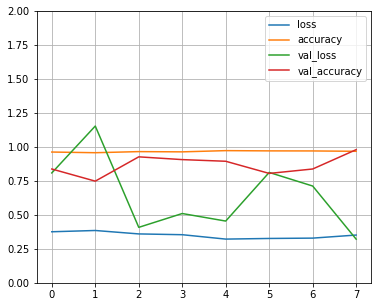

In [36]:
pd.DataFrame(history.history).plot(figsize=(6,5))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

In [37]:
loss_t, acc_t= new_model.evaluate(test_ds)
print(acc_t)

14/14 [==============================] - 3s 218ms/step - loss: 0.4080 - accuracy: 0.9630
0.96304851770401


In [38]:
y_pred=new_model.predict(test_ds)

14/14 [==============================] - 3s 224ms/step


In [39]:
y_pred=np.argmax(y_pred, axis=1)
y_pred

array([0, 2, 2, 0, 0, 2, 2, 1, 3, 2, 0, 1, 2, 2, 1, 2, 0, 2, 3, 1, 2, 0,
       2, 1, 2, 2, 3, 0, 1, 3, 3, 0, 2, 3, 3, 0, 0, 0, 2, 0, 1, 1, 1, 1,
       1, 2, 1, 1, 2, 3, 2, 0, 3, 3, 0, 2, 2, 3, 0, 0, 0, 0, 0, 1, 3, 2,
       1, 2, 0, 0, 2, 3, 3, 1, 1, 1, 3, 0, 2, 2, 1, 2, 0, 0, 2, 2, 3, 0,
       3, 2, 2, 3, 1, 0, 2, 1, 1, 0, 3, 3, 1, 2, 1, 2, 1, 1, 0, 1, 0, 1,
       2, 2, 1, 1, 2, 2, 1, 3, 3, 0, 2, 0, 2, 2, 3, 3, 0, 1, 0, 1, 0, 1,
       0, 3, 0, 2, 1, 3, 0, 3, 3, 2, 2, 1, 3, 2, 0, 1, 3, 2, 0, 2, 2, 1,
       3, 3, 2, 3, 0, 3, 2, 1, 2, 3, 0, 0, 1, 0, 1, 0, 2, 2, 3, 0, 1, 3,
       1, 3, 3, 1, 3, 1, 0, 1, 0, 2, 2, 0, 2, 1, 2, 0, 0, 1, 3, 1, 1, 1,
       1, 0, 1, 3, 3, 1, 3, 3, 0, 3, 0, 1, 3, 1, 0, 2, 3, 1, 0, 3, 0, 1,
       2, 2, 2, 2, 0, 3, 0, 1, 0, 3, 3, 0, 2, 0, 2, 2, 2, 1, 1, 0, 1, 2,
       2, 2, 0, 3, 0, 3, 2, 1, 3, 3, 1, 0, 3, 3, 2, 3, 2, 3, 2, 3, 2, 2,
       0, 1, 1, 0, 2, 1, 3, 3, 3, 0, 3, 0, 1, 1, 0, 3, 2, 0, 1, 0, 2, 3,
       0, 0, 1, 0, 1, 2, 0, 0, 0, 2, 3, 0, 0, 3, 3,

In [40]:
y_test = np.concatenate([y for x, y in test_ds], axis=0)
y_test

array([0, 2, 2, 0, 0, 2, 2, 1, 3, 2, 0, 1, 2, 2, 1, 2, 0, 2, 3, 1, 2, 0,
       2, 1, 2, 2, 3, 0, 1, 3, 3, 0, 2, 2, 3, 0, 0, 0, 2, 0, 1, 1, 1, 1,
       1, 2, 1, 1, 2, 3, 2, 0, 3, 3, 0, 3, 2, 3, 0, 0, 0, 0, 0, 1, 3, 2,
       1, 2, 0, 0, 2, 3, 3, 1, 1, 1, 3, 0, 2, 2, 1, 2, 0, 0, 2, 2, 3, 0,
       3, 2, 2, 3, 1, 0, 2, 1, 1, 0, 3, 3, 1, 2, 1, 3, 1, 1, 0, 1, 0, 1,
       3, 3, 1, 1, 2, 2, 1, 3, 3, 0, 2, 0, 2, 2, 3, 3, 0, 1, 0, 1, 0, 0,
       0, 3, 0, 2, 1, 3, 0, 3, 3, 2, 2, 1, 3, 2, 0, 1, 3, 2, 0, 2, 2, 1,
       3, 3, 2, 3, 0, 3, 2, 1, 2, 3, 0, 0, 1, 1, 1, 0, 2, 2, 3, 0, 1, 3,
       1, 3, 3, 1, 3, 1, 0, 1, 0, 2, 3, 0, 2, 1, 2, 0, 0, 1, 3, 1, 1, 1,
       1, 0, 1, 3, 3, 1, 3, 3, 0, 3, 0, 1, 3, 1, 0, 2, 3, 1, 0, 3, 0, 1,
       3, 2, 2, 2, 0, 3, 0, 1, 0, 3, 3, 0, 2, 0, 2, 2, 2, 1, 1, 0, 1, 2,
       2, 2, 0, 3, 0, 3, 2, 1, 3, 3, 1, 0, 3, 3, 2, 3, 2, 3, 2, 3, 2, 2,
       0, 1, 1, 0, 2, 1, 3, 3, 3, 0, 3, 0, 1, 1, 0, 3, 3, 0, 1, 0, 2, 3,
       0, 0, 1, 0, 1, 2, 0, 0, 0, 3, 3, 0, 0, 3, 3,

In [46]:
from sklearn.metrics import classification_report , confusion_matrix
report = classification_report(y_test, y_pred, target_names=['Closed', 'Open', 'no_yawn', 'yawn'],output_dict=True)
print(report) 

{'Closed': {'precision': 0.9908256880733946, 'recall': 0.9908256880733946, 'f1-score': 0.9908256880733946, 'support': 109}, 'Open': {'precision': 0.9908256880733946, 'recall': 0.9908256880733946, 'f1-score': 0.9908256880733946, 'support': 109}, 'no_yawn': {'precision': 0.8925619834710744, 'recall': 0.9908256880733946, 'f1-score': 0.9391304347826087, 'support': 109}, 'yawn': {'precision': 0.9893617021276596, 'recall': 0.8773584905660378, 'f1-score': 0.93, 'support': 106}, 'accuracy': 0.9630484988452656, 'macro avg': {'precision': 0.9658937654363808, 'recall': 0.9624588886965553, 'f1-score': 0.9626954527323495, 'support': 433}, 'weighted avg': {'precision': 0.9657311700320532, 'recall': 0.9630484988452656, 'f1-score': 0.9629219801184857, 'support': 433}}


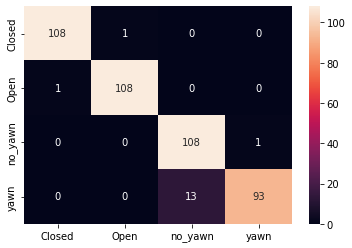

In [50]:
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, xticklabels=['Closed', 'Open', 'no_yawn', 'yawn'], yticklabels=['Closed', 'Open', 'no_yawn', 'yawn'], annot=True, fmt='d');

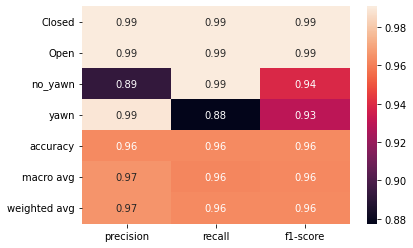

In [45]:
import seaborn as sns
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True);

In [42]:
new_model.save('/content/drive/MyDrive/Drowsiness_models/VGG19_Model')